In [2]:
%load_ext autoreload
%autoreload 2

import pickle
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from src.data.utils import flatten, parallelize_dataframe
from src.data.scrape_categories import EMOJI_CATEGORIES as emoji_categories
from src.analysis.embedded import calculate_vocabulary_variation
from src.data.cldr import cldr_anns_to_df
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter
from settings import AMBIGUITY_VARIATION, EMOJI_CATEGORIZED

pd.set_option('mode.chained_assignment', None)

sns.set_color_codes()
sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.7)
sns.set_style("white", {'axes.grid' : False})

### READ in with pre computed CIs

In [4]:
# AMBIGUITY_VARIATION = '/scratch/czestoch/ambiguity_variation.csv.gz'
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)
variations.head()

emoji                                         vocabulary  variation  \
0   #Ô∏è‚É£  Counter({'pound': 10, 'number': 9, 'hashtag': ...   0.496355   
1   *Ô∏è‚É£  Counter({'asterisk': 11, 'star': 9, 'pound': 2...   0.584016   
2    ¬©Ô∏è  Counter({'copyright': 17, 'copywrite': 3, 'c':...   0.276658   
3    ¬ÆÔ∏è  Counter({'r': 7, 'registered': 3, 'copyright':...   0.576165   
4    ‚ÄºÔ∏è  Counter({'exclamation': 11, 'important': 3, 's...   0.494922   

                                      mode_embedding  \
0  [-9.0013e-01 -4.3639e-03  4.7695e-01  1.4165e-...   
1  [ 4.6689e-02 -2.3131e-01  6.4926e-01 -2.9223e-...   
2  [-0.10602   -0.010289  -0.25982    0.52433    ...   
3  [ 3.6664e-01 -4.0631e-01  2.3680e-01  2.9964e-...   
4  [ 0.80197   -1.3284     0.83488   -0.13458    ...   

                                         CIs  
0  [0.35837585716197884, 0.6267261994754275]  
1  [0.41200086324362406, 0.7542600946038873]  
2   [0.1401009645106064, 0.4201737316739228]  
3   [0.4139707032711831, 0.7217792813700658]  
4   [0.3517648566963858, 0.6258342967978838]

In [5]:
variations.vocabulary = variations.vocabulary.apply(lambda x: x[8:-1])
variations.vocabulary = variations.vocabulary.apply(eval)
variations['vocabulary size'] = variations.vocabulary.apply(len)

In [9]:
spearmanr(variations.variation.values, variations["vocabulary size"].values)

SpearmanrResult(correlation=0.846405399833213, pvalue=0.0)

In [6]:
with open(EMOJI_CATEGORIZED, "rb") as f:
    categorized = pickle.load(f)

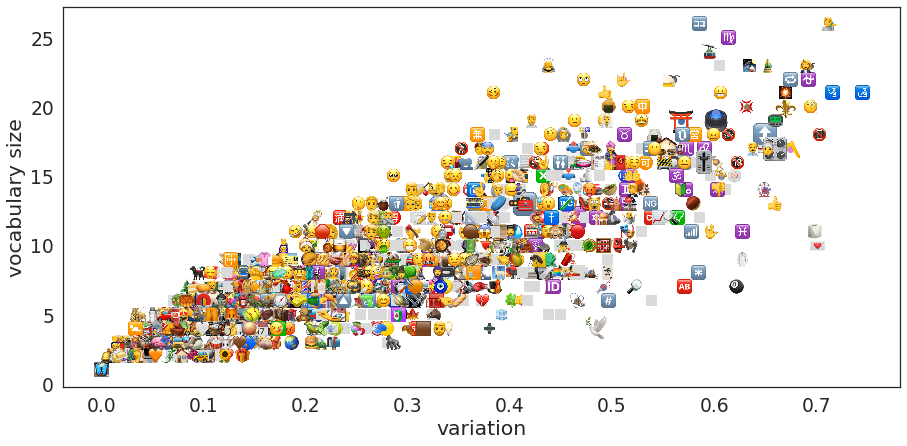

In [11]:
fig, ax = plt.subplots()
df = variations
for x, y, emoji in zip(df['variation'], df['vocabulary size'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.2, ax=ax)
    ax.scatter(x, y)
ax.set_xlabel("variation")
ax.set_ylabel("vocabulary size");

In [16]:
def assign_category(emoji):
    for category in categorized:
        if emoji in categorized[category]:
            return category

In [17]:
variations["category"] = variations.emoji.apply(assign_category)
variations = variations[variations.category != "flags"]

In [18]:
variations[variations.variation == 0].emoji

209           üåà
277           üçé
326           üçø
448           üêÑ
474           üêù
492           üêØ
533           üëó
573       üë®‚Äçüë©‚Äçüë¶
575       üë®‚Äçüë©‚Äçüëß
576     üë®‚Äçüë©‚Äçüëß‚Äçüë¶
577     üë®‚Äçüë©‚Äçüëß‚Äçüëß
614     üë©‚Äçüë©‚Äçüëß‚Äçüë¶
655           üíÑ
795           üîë
809           üîü
852          üï∑Ô∏è
877          üóùÔ∏è
1032          üöø
1132          ü•Ñ
1148          ü•ï
1164          ü••
1198          ü¶ã
Name: emoji, dtype: object

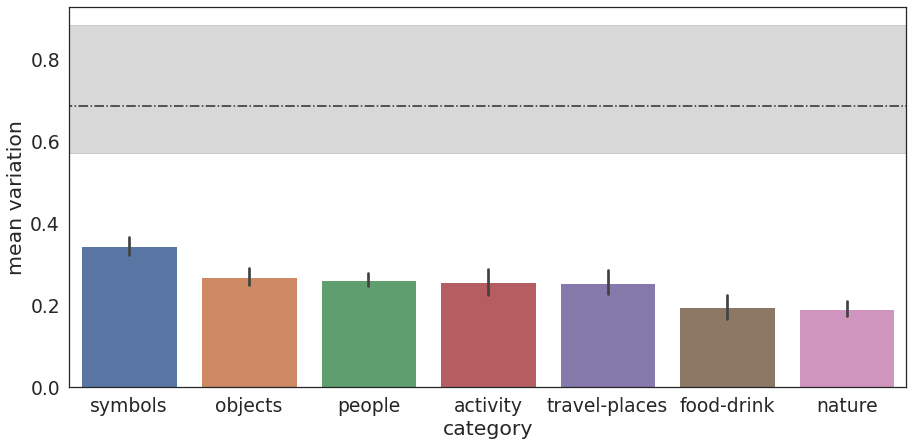

In [19]:
order = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
sns.barplot(x='category', y='variation', data=variations, ax=ax, order=order)
ax.set_ylabel("mean variation");

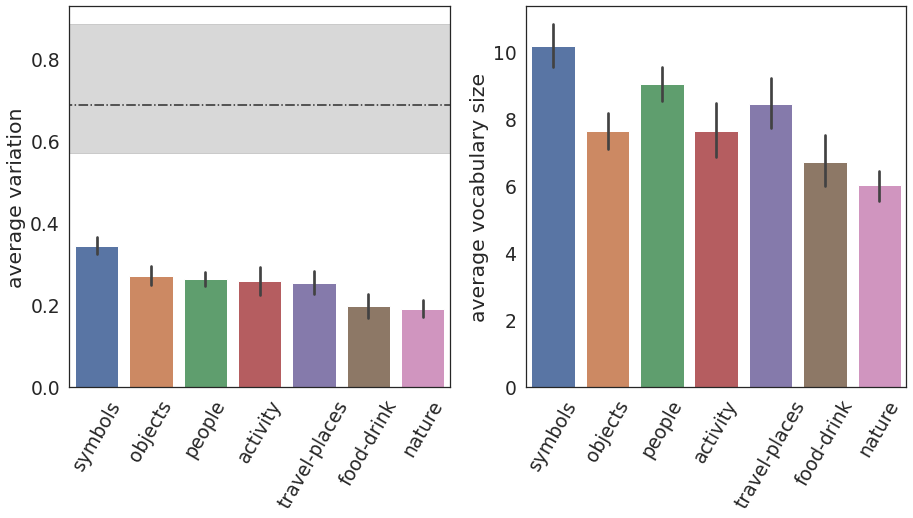

In [20]:
order = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

rotation = 60
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
sns.barplot(x='category', y='variation', data=variations, ax=ax1, order=order)
ax1.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax1.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
ax1.tick_params(axis='x', rotation=rotation)
ax1.set_ylabel("average variation")

sns.barplot(x='category', y='vocabulary size', data=variations, ax=ax2, order=order)
ax2.tick_params(axis='x', rotation=rotation)
ax2.set_ylabel("average vocabulary size")
ax1.set_xlabel("")
ax2.set_xlabel("");
# fig.text(0.5, 0.0, 'common X', ha='center');

In [22]:
japanese = ['üàÇÔ∏è','üàö','üàØ','üà≤','üà≥','üà¥','üàµ','üà∂','üà∑Ô∏è','üà∏',\
               'üàπ','üà∫','üâê','üâë','„äóÔ∏è','„äôÔ∏è','üÄÑ']
astrological = ['‚ôà','‚ôâ','‚ôä','‚ôã','‚ôå','‚ôç','‚ôé','‚ôè','‚ôê','‚ôë','‚ôí','‚ôì', '‚õé']
religious = ['üïâÔ∏è', 'üïé', '‚ò¶Ô∏è','‚ò™Ô∏è','‚òØÔ∏è', '‚úùÔ∏è','‚ú°Ô∏è']
hearts = ['üíì','üíî','üíï','üíñ','üíó','üíò','üíô','üíö','üíõ','üíú','üíù','üíû','üíü']


others = set(variations[variations.category == "symbols"].emoji.unique()) \
                - set(japanese) - set(astrological) - set(religious) - set(hearts)

symbols_subcategories = {"Japanese": japanese, "astrological": astrological,\
                        "religious": religious, "hearts": hearts, "others": others}

In [23]:
symbols_df = variations[variations.category == "symbols"]

def assign_subcategory(emoji):
    for subcategory in symbols_subcategories:
        if emoji in symbols_subcategories[subcategory]:
            return subcategory

symbols_df["subcategory"] = symbols_df.emoji.apply(assign_subcategory)

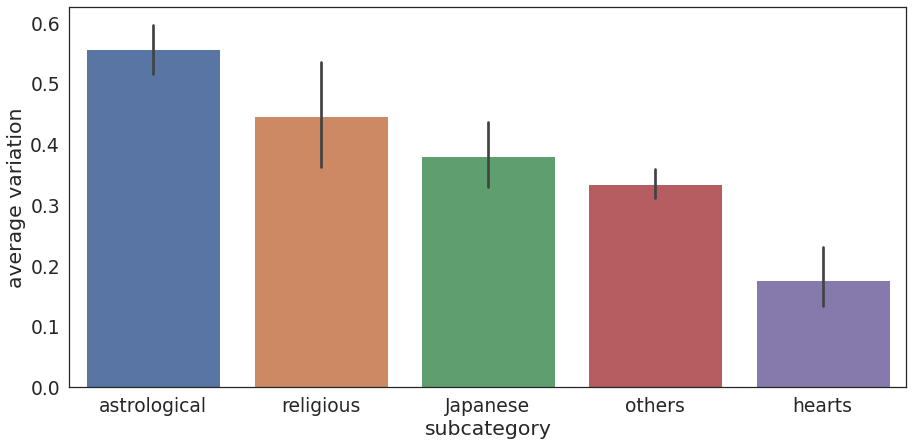

In [24]:
order = symbols_df.groupby("subcategory").variation.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots()
sns.barplot(x='subcategory', y='variation', data=symbols_df, ax=ax, order=order)
ax.set_ylabel("average variation");

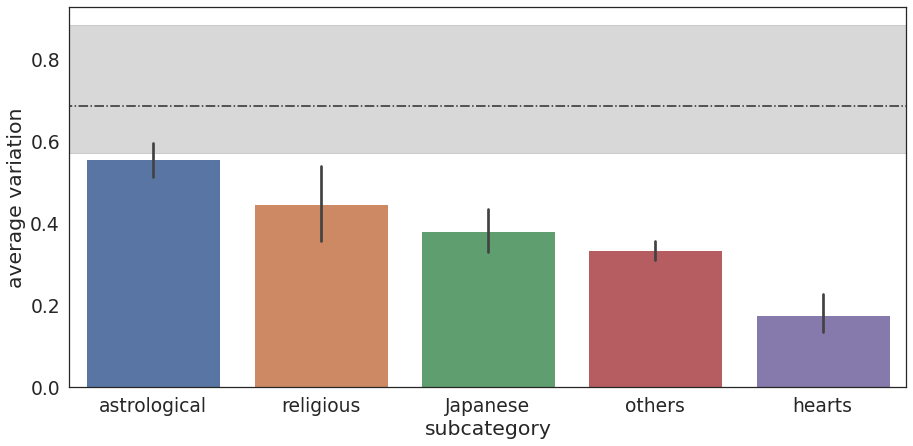

In [25]:
order = symbols_df.groupby("subcategory").variation.mean().sort_values(ascending=False).index.tolist()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black', label='baseline')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
sns.barplot(x='subcategory', y='variation', data=symbols_df, ax=ax, order=order)
ax.set_ylabel("average variation");

In [27]:
subcategories = {'professions': ['üßë‚Äç‚öïÔ∏è' ,'üë®‚Äç‚öïÔ∏è','üë©‚Äç‚öïÔ∏è' ,'üßë‚Äçüéì' ,'üë®‚Äçüéì' ,'üë©‚Äçüéì',
'üßë‚Äçüè´' ,'üë®‚Äçüè´' ,'üë©‚Äçüè´' ,'üßë‚Äç‚öñÔ∏è','üë®‚Äç‚öñÔ∏è','üë©‚Äç‚öñÔ∏è' ,'üßë‚Äçüåæ',
'üë®‚Äçüåæ','üë©‚Äçüåæ' ,'üßë‚Äçüç≥' ,'üë®‚Äçüç≥','üë©‚Äçüç≥','üßë‚Äçüîß',
'üë®‚Äçüîß','üë©‚Äçüîß','üßë‚Äçüè≠','üë®‚Äçüè≠', 'üë©‚Äçüè≠','üßë‚Äçüíº',
'üë®‚Äçüíº','üë©‚Äçüíº','üßë‚Äçüî¨','üë®‚Äçüî¨','üë©‚Äçüî¨','üßë‚Äçüíª',
'üë®‚Äçüíª','üë©‚Äçüíª','üßë‚Äçüé§','üë®‚Äçüé§','üë©‚Äçüé§','üßë‚Äçüé®','üë®‚Äçüé®',
'üë©‚Äçüé®','üßë‚Äç‚úàÔ∏è','üë®‚Äç‚úàÔ∏è', 'üë©‚Äç‚úàÔ∏è','üßë‚ÄçüöÄ' ,'üë®‚ÄçüöÄ',
'üë©‚ÄçüöÄ' ,'üßë‚Äçüöí','üë®‚Äçüöí','üë©‚Äçüöí' ,'üëÆ','üëÆ‚Äç‚ôÇÔ∏è', 
'üëÆ‚Äç‚ôÄÔ∏è','üïµÔ∏è' ,'üïµÔ∏è‚Äç‚ôÇÔ∏è','üïµÔ∏è‚Äç‚ôÄÔ∏è','üíÇ' ,'üíÇ‚Äç‚ôÇÔ∏è' ,
'üíÇ‚Äç‚ôÄÔ∏è','ü•∑','üë∑' ,'üë∑‚Äç‚ôÇÔ∏è','üë∑‚Äç‚ôÄÔ∏è', 'ü§¥','üë∏'],
   
'clothes & accessories': ['üß≥' ,'üåÇ' , '‚òÇÔ∏è' ,'üéÉ' ,'üßµ' ,
'üß∂' ,'üëì' ,'üï∂Ô∏è' ,'ü•Ω' ,'ü•º' ,'ü¶∫' ,
'üëî' ,'üëï' ,'üëñ' ,'üß£' ,'üß§' ,'üß•' ,
'üß¶' ,'üëó' ,'üëò' ,'ü•ª' ,'ü©±' ,'ü©≤' ,
'ü©≥' ,'üëô' ,'üëö' ,'üëõ' ,'üëú' ,'üëù' ,
'üéí' ,'ü©¥' ,'üëû' ,'üëü' ,'ü•æ' ,'ü•ø' ,
'üë†' ,'üë°' ,'ü©∞' ,'üë¢' ,'üëë' ,'üëí' ,
'üé©' ,'üéì' ,'üß¢' ,'ü™ñ' ,'‚õëÔ∏è' ,'üíÑ' ,'üíç' ,'üíº'],
 
 'faces': [ 'üòÄ' ,'üòÉ' ,'üòÑ','üòÅ' ,'üòÜ' ,
'üòÖ' ,'ü§£' ,'üòÇ' ,'üôÇ' ,'üôÉ' ,'üòâ' ,
'üòä' ,'üòá' ,'ü•∞' ,'üòç' ,'ü§©' ,'üòò' ,
'üòó' ,'‚ò∫Ô∏è' ,'üòö','üòô','ü•≤' ,'üòã' ,'üòõ' ,
'üòú' ,'ü§™' ,'üòù' ,'ü§ë' ,'ü§ó','ü§≠' ,'ü§´' ,
'ü§î' ,'ü§ê' ,'ü§®' ,'üòê' ,'üòë' ,'üò∂' ,'üò∂‚Äçüå´Ô∏è' ,
'üòè','üòí' ,'üôÑ' ,'üò¨' ,'üòÆ‚Äçüí®','ü§•' ,'üòå',
'üòî' ,'üò™','ü§§' ,'üò¥','üò∑','ü§í' ,'ü§ï' ,'ü§¢' ,
'ü§Æ' ,'ü§ß' ,'ü•µ' ,'ü•∂' ,'ü•¥','üòµ' ,'üòµ‚Äçüí´' ,
'ü§Ø' ,'ü§†' ,'ü•≥' ,'ü•∏','üòé','ü§ì' ,'üßê','üòï',
'üòü' ,'üôÅ' ,'‚òπÔ∏è' ,'üòÆ' ,'üòØ','üò≤','üò≥' ,'ü•∫',
'üò¶' ,'üòß' ,'üò®' ,'üò∞','üò•' ,'üò¢' ,'üò≠' ,'üò±' ,'üòñ' ,
'üò£' ,'üòû' ,'üòì' ,'üò©','üò´' ,'ü•±' ,'üò§' ,'üò°' ,
'üò†' ,'ü§¨' ,'üòà' ,'üëø' ,'üíÄ' ,'‚ò†Ô∏è' ,'üí©' ,'ü§°' ,
'üëπ' ,'üë∫' ,'üëª' ,'üëΩ' ,'üëæ' ,'ü§ñ' ,'üò∫' ,'üò∏' ,
'üòπ' ,'üòª' ,'üòº' ,'üòΩ' ,'üôÄ' ,'üòø' ,'üòæ' ],
 
 
 'hands & gestures': [ 'üëã' ,'ü§ö' ,'üñêÔ∏è','‚úã' ,'üññ' ,'üëå' ,
'ü§å' ,'ü§è' ,'‚úåÔ∏è' ,'ü§û' ,'ü§ü' ,'ü§ò' ,'ü§ô' ,
'üëà' ,'üëâ' ,'üëÜ' ,'üñï' ,'üëá' ,'‚òùÔ∏è' ,'üëç' ,
'üëé' ,'‚úä' ,'üëä' ,'ü§õ' ,'ü§ú' ,'üëè' , 'üôå' ,
'üëê' ,'ü§≤' ,'ü§ù' ,'üôè' ,'‚úçÔ∏è' ,'üíÖ' ,'ü§≥' ,'üí™'],
 
 'letters & numbers': ['üîô', 'üîö',  'üîõ',  'üîú',  'üîù', 
       'üîü', 'üî†', 'üî°', 'üî¢','üî£', 'üî§',
       'üÖ∞Ô∏è', 'üÖ±Ô∏è', 'üÖæÔ∏è', 'üÖøÔ∏è', 'üÜé','üÜë', 
       'üÜí', 'üÜì', 'üÜî','üÜï', 'üÜñ', 'üÜó',
       'üÜò', 'üÜô','üÜö'],
 
 
 'arrows': ['‚§¥Ô∏è', '‚§µÔ∏è',  '‚¨ÖÔ∏è', '‚û°Ô∏è', '‚¨ÜÔ∏è', '‚¨áÔ∏è','‚ÜîÔ∏è', 
            '‚ÜïÔ∏è', '‚ÜñÔ∏è','‚ÜóÔ∏è', '‚ÜòÔ∏è', '‚ÜôÔ∏è', '‚Ü©Ô∏è','‚Ü™Ô∏è',  
            'üîÉ', 'üîÑ' ], 
 
 
 'buttons & mobile': ['‚èèÔ∏è',  '‚è©', '‚è™',  '‚è´', '‚è¨', 'üîÄ', 'üîÅ', 'üîÇ',\
       '‚è≠Ô∏è',  '‚èÆÔ∏è',  '‚èØÔ∏è',  '‚è∏Ô∏è',  '‚èπÔ∏è', \
       '‚è∫Ô∏è', '‚ñ∂Ô∏è', '‚óÄÔ∏è', 'üîº', 'üîΩ', 'üì≥', 'üì¥', 'üì∂', 'üîÖ', 'üîÜ', 'üîá',\
       'üîà',  'üîâ', 'üîä', 'üîî', 'üîï' ],
 
 
 'geometrical': [ '\U0001f7e0', '\U0001f7e1',  '\U0001f7e2', '\U0001f7e3', 
       '\U0001f7e4', '\U0001f7e5', '\U0001f7e6', '\U0001f7e7', '\U0001f7e8', 
       '\U0001f7e9', '\U0001f7ea', '\U0001f7eb', '‚óªÔ∏è', '‚óºÔ∏è', '‚óΩ', '‚óæ', 
        '‚ö™', '‚ö´', 'üõë', '‚¨õ', '‚¨ú', 'üî≤', 'üî≥', 'üî¥', 'üîµ', 'üî∂', 'üî∑',
        'üî∏', 'üîπ', 'üî∫', 'üîª', 'üîò', '‚ñ™Ô∏è', '‚ñ´Ô∏è'],

 'Japanese' : ['üàÇÔ∏è','üàö','üàØ','üà≤','üà≥','üà¥','üàµ','üà∂','üà∑Ô∏è','üà∏', \
               '‚ô®Ô∏è', 'üí¢', '„Ä∞Ô∏è', '‚û∞', '‚ûø', 'üí†', 'üéê', 'üàπ','üà∫',\
               'üâê','üâë','„äóÔ∏è','„äôÔ∏è','üÄÑ', 'üàÅ', 'üé¥', 'üî∞', '„ÄΩÔ∏è', '‚≠ï',\
               'üìõ', 'üíπ', 'üí±', 'üéé', 'üéè'],
'astrological' : ['‚ôà','‚ôâ','‚ôä','‚ôã','‚ôå','‚ôç','‚ôé','‚ôè','‚ôê','‚ôë','‚ôí','‚ôì', '‚õé'],
'religious' : ['üïâÔ∏è', 'üïé', '‚ò¶Ô∏è','‚ò™Ô∏è','‚òØÔ∏è', '‚úùÔ∏è','‚ú°Ô∏è', 'üõê', 'üîØ', '‚ò∏Ô∏è'],
'hearts' : ['üíì','üíî','üíï','üíñ','üíó','üíò','üíô','üíö','üíõ','üíú','üíù','üíû','üíü',
           '‚ù£Ô∏è', '‚ù§Ô∏è', '\U0001f9e1', '\U0001f90e', '\U0001f90d', 'üñ§'],
                 
'Public Information Symbols': [
    '‚ìÇÔ∏è', '‚ò¢Ô∏è', '‚ò£Ô∏è', '‚ôªÔ∏è', '‚ôø', '‚öïÔ∏è', '‚ö†Ô∏è','‚õî',\
    'üîû', 'üö´', 'üö≠', 'üöÆ', 'üöØ', 'üö±', 'üö≥', 'üö∑', 
    'üö∏', 'üöπ', 'üö∫', 'üöª', 'üöº', 'üöæ', 'üèß', 'üìµ', '‚ÑπÔ∏è', 'üö∞',
    ],
"nature": ['üåÄ'], "activity": ['üé¶', 'üèÉ'], "objects": ['üì¢', 'üì£'],

}

In [28]:
def assign_subcategory(row):
    for subcategory in subcategories:
        if row.emoji in subcategories[subcategory]:
            return subcategory
    return row.category

variations["category"] = variations.apply(assign_subcategory, axis=1)
variations = variations.replace({"symbols": "symbols & signs"})

In [29]:
plt.rcParams['figure.figsize']

[15.0, 7.0]

In [58]:
sns.set(rc={'figure.figsize':(14, 14)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

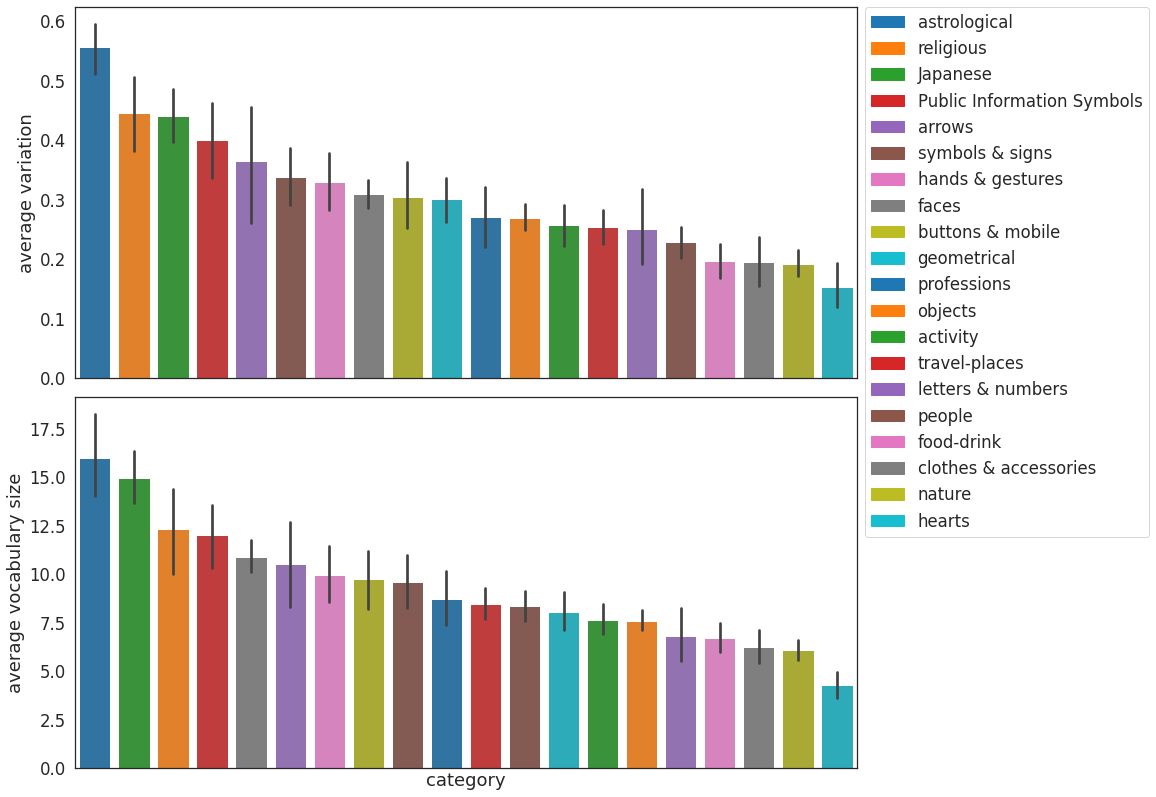

In [101]:
sns.set_palette("tab10", 20)

order1 = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
sns.barplot(x='category', y='variation', data=variations, ax=ax1, order=order1)
ax1.set_ylabel("average variation")
# ax1.tick_params('x', rotation=90)
ax1.set_xlabel("")

ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

order2 = variations.groupby("category")["vocabulary size"].mean().sort_values(ascending=False).index.tolist()
pal = sns.color_palette()
color_map = dict(zip(order1, pal.as_hex()))
palette = [color_map[bar] for bar in order2]

sns.barplot(x='category', y='vocabulary size', data=variations, ax=ax2, order=order2, palette=palette)
ax2.set_ylabel("average vocabulary size")
# ax2.tick_params('x', rotation=90);

ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)


handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in order1]
plt.legend(handles, order1, bbox_to_anchor=(1, 0.6), loc='lower left')

plt.subplots_adjust(hspace=0.05)

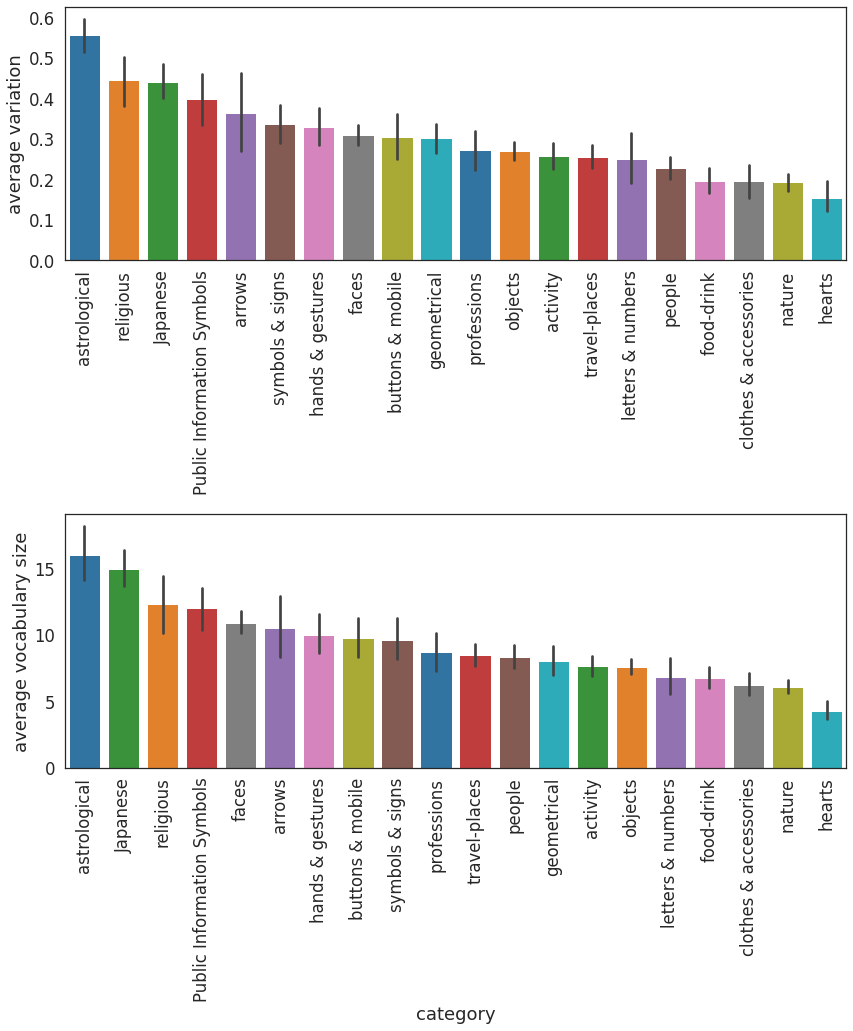

In [102]:
sns.set_palette("tab10", 20)

order1 = variations.groupby("category").variation.mean().sort_values(ascending=False).index.tolist()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
sns.barplot(x='category', y='variation', data=variations, ax=ax1, order=order1)
ax1.set_ylabel("average variation")
ax1.tick_params('x', rotation=90)
ax1.set_xlabel("")

# ax1.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)

order2 = variations.groupby("category")["vocabulary size"].mean().sort_values(ascending=False).index.tolist()
pal = sns.color_palette()
color_map = dict(zip(order1, pal.as_hex()))
palette = [color_map[bar] for bar in order2]

sns.barplot(x='category', y='vocabulary size', data=variations, ax=ax2, order=order2, palette=palette)
ax2.set_ylabel("average vocabulary size")
ax2.tick_params('x', rotation=90);

# ax2.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False)


# handles = [plt.Rectangle((0,0),1,1, color=color_map[label]) for label in order1]
# plt.legend(handles, order1, bbox_to_anchor=(1, 0.6), loc='lower left')

plt.subplots_adjust(hspace=1)